In [3]:
import glob
from random import shuffle, choice
from tqdm import trange
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/henistein/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle', 'choice']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
img_files = glob.glob('GTSRB/*')
print(len(img_files))

26639


In [7]:
imgs_by_class = {}
for f in img_files:
  cls_name = f.split('/')[-1].split('_')[0]
  if cls_name not in imgs_by_class.keys():
    imgs_by_class[cls_name] = [f]
  else:
    imgs_by_class[cls_name].append(f)
# shuffle
for cls in imgs_by_class.keys():
  shuffle(imgs_by_class[cls])

<BarContainer object of 43 artists>

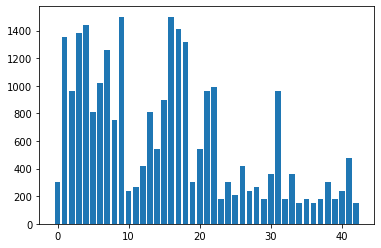

In [8]:
# distribution by class
distr_by_class = [len(imgs_by_class[cls]) for cls in imgs_by_class.keys()]
plt.bar(range(0, len(distr_by_class)), distr_by_class)

In [9]:
# split data into 80/20 where 80 is for train, 10 for val, and 10 for test
train, val, test = {}, {}, {}
for cls, imgs in imgs_by_class.items():
  n = len(imgs)
  train[cls] = imgs[:int(n*0.8)]
  val[cls] = imgs[int(n*0.8):int(n*0.9)]
  test[cls] = imgs[int(n*0.9):]

In [10]:
# Create augmentations
import albumentations as A
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.3),
    A.Blur(blur_limit=(3, 5), p=0.2),
    A.ElasticTransform(p=0.2),
])

def augment_set(set_, path):
  target_size = max([len(set_[cls]) for cls in set_.keys()])
  for cls in set_.keys():
    n = target_size - len(set_[cls])
    for i in trange(n):
      random_img = choice(set_[cls])
      img = imread(random_img)
      aug = transform(image=img)['image']
      name = random_img.split('/')[-1].split('.')[0]
      # save augmented img
      imsave(f'{path}/{name}_aug_{i}.jpg', aug)
    for f in set_[cls]:
      name = f.split('/')[-1]
      # save original img
      imsave(f'{path}/{name}', img)

In [12]:
# Augmentation on train set
print('Augment train set')
augment_set(train, 'GTSRB_AUG_TRAIN')
# Augmentation on val set
print('Augment val set')
augment_set(val, 'GTSRB_AUG_VAL')
# Augmentation on test set
print('Augment test set')
augment_set(test, 'GTSRB_AUG_TEST')

Augment train set


100%|████████████████████████████████████████| 600/600 [00:02<00:00, 221.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████| 480/480 [00:02<00:00, 214.61it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████| 1080/1080 [00:04<00:00, 223.34it/s]


Augment val set


100%|██████████████████████████████████████████| 75/75 [00:00<00:00, 214.27it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████| 60/60 [00:00<00:00, 240.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████| 135/135 [00:00<00:00, 263.00it/s]


Augment test set


100%|██████████████████████████████████████████| 75/75 [00:00<00:00, 299.56it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████| 60/60 [00:00<00:00, 204.25it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████| 135/135 [00:00<00:00, 206.17it/s]


In [4]:
# load files with augmentations
train_set = glob.glob('GTSRB_AUG_TRAIN/*')
test_set = glob.glob('GTSRB_AUG_TEST/*')
val_set = glob.glob('GTSRB_AUG_VAL/*')

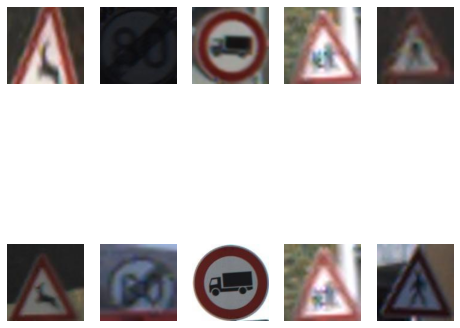

In [17]:
# Show some augmented examples
augmented_files = glob.glob('GTSRB_AUG_TRAIN/*_aug*')[:5]
original_files = [f.split('_aug')[0]+'.jpg' for f in augmented_files]
aug_orig_files = augmented_files + original_files

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,8))
axes = axes.flatten()
for i in range(10):     
  axes[i].imshow(imread(aug_orig_files[i]))
  axes[i].axis('off')

<BarContainer object of 43 artists>

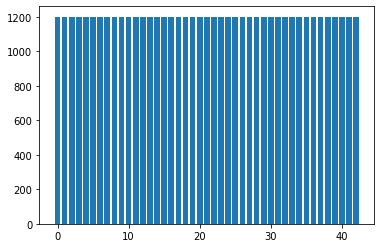

In [18]:
# Show train distribution by class after augmentation
imgs_aug_by_class = {}
for f in train_set:
  cls_name = f.split('/')[-1].split('_')[0]
  if cls_name not in imgs_aug_by_class.keys():
    imgs_aug_by_class[cls_name] = [f]
  else:
    imgs_aug_by_class[cls_name].append(f)

distr_by_class = [len(imgs_aug_by_class[cls]) for cls in imgs_aug_by_class.keys()]
plt.bar(range(0, len(distr_by_class)), distr_by_class)

In [25]:
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [33]:
class MyDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
    self.transform = transforms.Compose([
      transforms.Resize((128, 128)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, index):
    # load img
    img_path = self.dataset[index]
    img = Image.open(img_path)
    img = self.transform(img)
    # load cls
    cls = torch.tensor(int(img_path.split('/')[-1].split('_')[0])).long()
    return img, cls

In [36]:
# Create train, val and test dataloaders
BS = 16
train_dataloader = DataLoader(MyDataset(train_set), batch_size=BS, collate_fn=None, shuffle=True)
val_dataloader = DataLoader(MyDataset(val_set), batch_size=BS, collate_fn=None, shuffle=True)
test_dataloader = DataLoader(MyDataset(test_set), batch_size=BS, collate_fn=None, shuffle=True)

In [ ]:
for imgs,clss in train_dataloader:
  print(imgs.shape)
  print(clss.shape)
  break